In [2]:
# Import Packages
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.preprocessing import image
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-12-11 15:49:36.982806: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-11 15:49:37.003690: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-11 15:49:37.852217: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-11 15:49:40.484779: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

# Paso 1:

 Carga del conjunto de datos
El conjunto de datos se encuentra en este link. Descarga la carpeta y descomprime los archivos. Ahora tendrás una carpeta con el dataset y una carpeta llamada train que contiene más de 25.000 archivos de imagen (formato .jpg) de perros y gatos. Las fotos están etiquetadas por su nombre de archivo, con la palabra dog o cat.

In [3]:
# pasar las imagenes a las carpetas divididas en train y test..
# este codigo lo use solo una vez para hacer la division de imagenes
("""
import os
import shutil
import random

# Carpeta donde están TODAS las imágenes mezcladas
data_dir = "/workspaces/betaniammc-machine-learning/data/dogs-vs-cats"

# Carpetas destino
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

train_cats = os.path.join(train_dir, "cats")
train_dogs = os.path.join(train_dir, "dogs")
test_cats  = os.path.join(test_dir, "cats")
test_dogs  = os.path.join(test_dir, "dogs")

dest_folders = [train_cats, train_dogs, test_cats, test_dogs]


# --------------------------------------------------------------------
# 2. CREAR CARPETAS LIMPIAS
# --------------------------------------------------------------------
for folder in dest_folders:
    os.makedirs(folder, exist_ok=True)
    print(f"📁 Creada carpeta: {folder}")

# --------------------------------------------------------------------
# 3. OBTENER LISTA DE IMÁGENES
# --------------------------------------------------------------------
all_images = [img for img in os.listdir(data_dir) if img.lower().endswith(".jpg")]

cat_images = [img for img in all_images if img.lower().startswith("cat")]
dog_images = [img for img in all_images if img.lower().startswith("dog")]

print(f"\nTotal gatos al principio: {len(cat_images)}")
print(f"Total perros: {len(dog_images)}\n")

# --------------------------------------------------------------------
#  4. FUNCIÓN PARA SPLIT 80/20 Y COPIAR IMÁGENES
# --------------------------------------------------------------------
def split_and_copy(images, train_path, test_path, train_ratio=0.8):
    random.shuffle(images)
    split_idx = int(len(images) * train_ratio)

    train_imgs = images[:split_idx]
    test_imgs  = images[split_idx:]

    for img in train_imgs:
        shutil.move(os.path.join(data_dir, img), train_path)

    for img in test_imgs:
        shutil.move(os.path.join(data_dir, img), test_path)

    print(f"{train_path}: {len(train_imgs)} train")
    print(f"{test_path}:  {len(test_imgs)} test\n")

# --------------------------------------------------------------------
#  5. SPLIT PARA GATOS Y PERROS
# --------------------------------------------------------------------
split_and_copy(cat_images, train_cats, test_cats)
split_and_copy(dog_images, train_dogs, test_dogs)
""")



'\nimport os\nimport shutil\nimport random\n\n# Carpeta donde están TODAS las imágenes mezcladas\ndata_dir = "/workspaces/betaniammc-machine-learning/data/dogs-vs-cats"\n\n# Carpetas destino\ntrain_dir = os.path.join(data_dir, "train")\ntest_dir = os.path.join(data_dir, "test")\n\ntrain_cats = os.path.join(train_dir, "cats")\ntrain_dogs = os.path.join(train_dir, "dogs")\ntest_cats  = os.path.join(test_dir, "cats")\ntest_dogs  = os.path.join(test_dir, "dogs")\n\ndest_folders = [train_cats, train_dogs, test_cats, test_dogs]\n\n\n# --------------------------------------------------------------------\n# 2. CREAR CARPETAS LIMPIAS\n# --------------------------------------------------------------------\nfor folder in dest_folders:\n    os.makedirs(folder, exist_ok=True)\n    print(f"📁 Creada carpeta: {folder}")\n\n# --------------------------------------------------------------------\n# 3. OBTENER LISTA DE IMÁGENES\n# --------------------------------------------------------------------\nall_i

Total gatos al principio: 12500
Total perros: 12500

/workspaces/betaniammc-machine-learning/data/dogs-vs-cats/train/cats: 10000 train
/workspaces/betaniammc-machine-learning/data/dogs-vs-cats/test/cats:  2500 test

/workspaces/betaniammc-machine-learning/data/dogs-vs-cats/train/dogs: 10000 train
/workspaces/betaniammc-machine-learning/data/dogs-vs-cats/test/dogs:  2500 test

# Paso 2: 

Visualiza la información de entrada

El primer paso cuando nos enfrentamos a un problema de clasificación de imágenes es obtener toda la información posible a través de ellas. Por lo tanto, carga e imprime las primeras nueve fotos de perros en una sola figura. Repite lo mismo para los gatos. Puedes ver que las fotos son a color y tienen diferentes formas y tamaños.

Esta variedad de tamaños y formatos debe solucionarse antes de entrenar el modelo. Asegúrate de que todas tengan un tamaño fijo de 200x200 píxeles.

Como podrás ver, son una gran cantidad de imágenes, asegúrate de seguir las siguientes normas:

Si tienes más de 12 gigabytes de RAM, usa la API de procesamiento de imágenes de Keras para cargar las 25.000 fotos en el conjunto de datos de entrenamiento y remodelarlas a fotos cuadradas de 200×200 píxeles. La etiqueta también debe determinarse para cada foto en función de los nombres de archivo. Se debe guardar una tupla de fotos y etiquetas.
Si no tienes más de 12 gigabytes de RAM, carga las imágenes progresivamente usando la clase Keras ImageDataGenerator y la función flow_from_directory(). Esto será más lento de ejecutar, pero se ejecutará en hardware de menor capacidad. Esta función prefiere que los datos se dividan en directorios train y test separados, y debajo de cada directorio para tener un subdirectorio para cada clase.
Una vez tengas todas las imágenes procesadas, crea un objeto ImageDataGenerator para datos de entrenamiento y prueba. Luego pasa la carpeta que tiene datos de entrenamiento al objeto trdata y, de manera similar, pasa la carpeta que tiene datos de prueba al objeto tsdata. De esta forma, se etiquetarán las imágenes automáticamente y estará todo listo para entrar a la red.

## visualizacion de imagenes

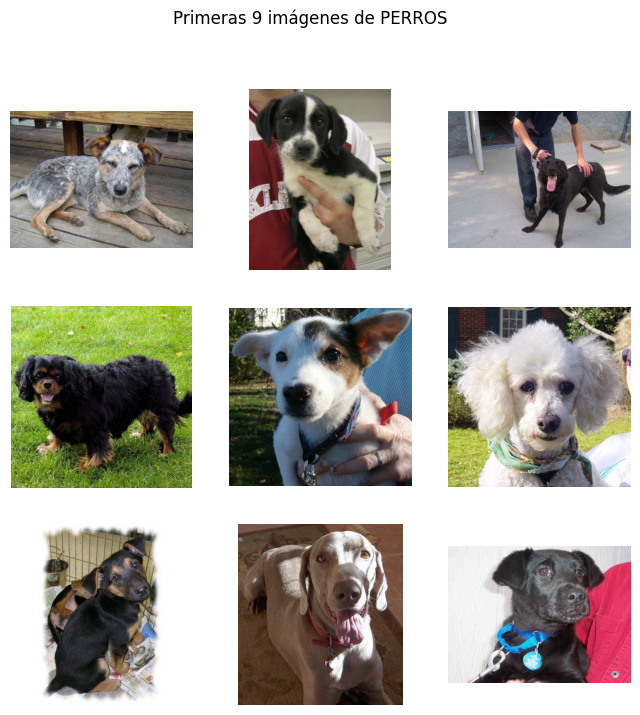

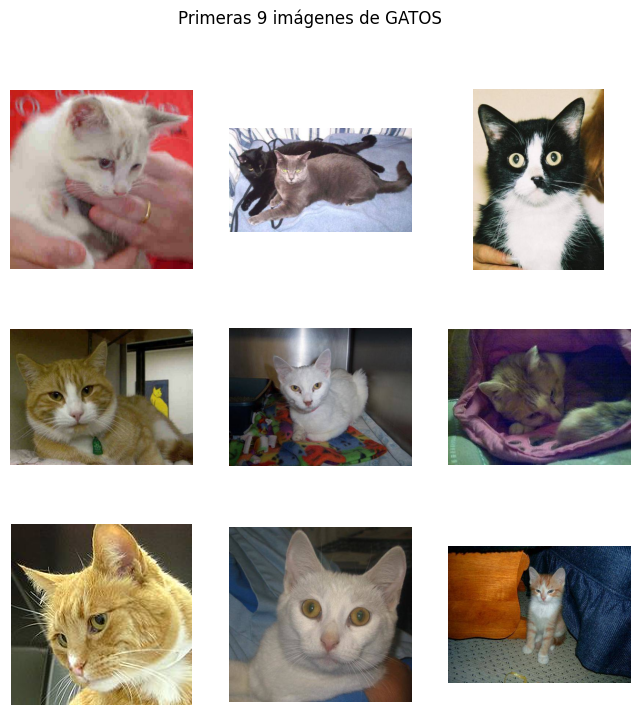

In [4]:
train_dir = "/workspaces/betaniammc-machine-learning/data/dogs-vs-cats/train"
cats_dir = os.path.join(train_dir, "cats")
dogs_dir = os.path.join(train_dir, "dogs")

def show_examples(folder, title):
    images = os.listdir(folder)[:9]   # tomar 9 imágenes
    plt.figure(figsize=(8, 8))
    plt.suptitle(title)

    for i, img in enumerate(images):
        img_path = os.path.join(folder, img)
        image = Image.open(img_path)

        plt.subplot(3, 3, i+1)
        plt.imshow(image)
        plt.axis("off")

    plt.show()

show_examples(dogs_dir, "Primeras 9 imágenes de PERROS")
show_examples(cats_dir, "Primeras 9 imágenes de GATOS")

## cambio del temaño de las imagenes y creacion de los generadores

In [5]:
IMG_SIZE = (200, 200)

trdata = ImageDataGenerator(rescale=1./255)
tsdata = ImageDataGenerator(rescale=1./255)

train_data = trdata.flow_from_directory(
    "/workspaces/betaniammc-machine-learning/data/dogs-vs-cats/train",
    target_size=(IMG_SIZE),
    batch_size=32,
    class_mode='binary'
)

test_data = tsdata.flow_from_directory(
    "/workspaces/betaniammc-machine-learning/data/dogs-vs-cats/test",
    target_size=(IMG_SIZE),
    batch_size=32,
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

model = Sequential()

model.add(Conv2D(input_shape=(200,200,3), filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())

model.add(Dense(units=4096, activation="relu"))
model.add(Dense(units=4096, activation="relu"))
model.add(Dense(units=1, activation="sigmoid"))   # SOLO 2 clases: perro o gato

/home/vscode/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-12-11 15:49:43.283869: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [ ]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

: 

In [ ]:
history = model.fit(
    train_data,
    epochs=1,
    validation_data=test_data
)

  1/625 ━━━━━━━━━━━━━━━━━━━━ 4:05:47 24s/step - accuracy: 0.5312 - loss: 0.6932